In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

In [2]:
#vgg16を使う
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms

In [3]:
vgg16 = models.vgg16(pretrained=True,progress=True)
softmax=nn.Softmax(dim=1)
vgg16 = vgg16.cuda()

In [6]:
image_size = (256, 256) 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])

img = Image.open('lion.jpg')
img = image_transform(img)
img = img.unsqueeze(0)

# 認識結果の top-5 の結果の表示
SYNSET_FILE='1000.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
synset=open(SYNSET_FILE).read().split('\n')


In [7]:
#画像の種類を認識し、正しいカテゴリーを確認する
img = img.cuda()
vgg16.eval()
with torch.no_grad():
    out=softmax(vgg16(img)).cpu().numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.98340952 n02129165 lion, king of beasts, Panthera leo
[2] 0.00183547 n02112137 chow, chow chow
[3] 0.00143139 n02115913 dhole, Cuon alpinus
[4] 0.00098542 n02106030 collie
[5] 0.00082928 n02108551 Tibetan mastiff


In [ ]:
top5idx[0]

In [8]:
occluding_size = 64 
occluding_pixel = 0 #occluderでマスクされたピクセルを０にする
occluding_stride = 4

image = Image.open("lion.jpg")
image = image.resize((256,256))

height = 256
width = 256
output_height = int(math.ceil((height-occluding_size)/occluding_stride+1))
output_width = int(math.ceil((width-occluding_size)/occluding_stride+1))

heatmap = np.zeros((output_height, output_width))

for h in range(output_height):
    for w in range(output_width):
        #occluder region
        h_start = h*occluding_stride
        w_start = w*occluding_stride
        h_end = min(height, h_start + occluding_size)
        w_end = min(width, w_start + occluding_size)
        
        input_image = np.array(image)
        input_image[h_start:h_end,w_start:w_end,:] = occluding_pixel #特定の部分をマスクする
        input_image = Image.fromarray(np.uint8(input_image))
        input_image = image_transform(input_image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.cuda()
        
        vgg16.eval()
        with torch.no_grad():
            probs = softmax(vgg16(input_image)).cpu().numpy()[0]

        top1 = top5idx[0]
        heatmap[h,w] = probs[top1] # the probability of the correct class
        

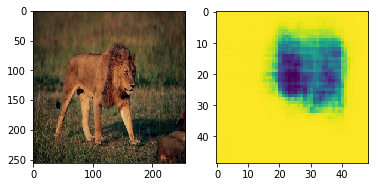

In [9]:
image = Image.open("lion.jpg")
image = image.resize((256,256))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(heatmap, interpolation='nearest')
plt.show()

In [ ]:
heatmap